# Etude des motifs de préférences musicales

Dans ce notebook, on cherche à identifier si certains styles musicaux sont systématiquement préférés à d'autres ou inversement. On cherche donc dans un premier temps à les comparer entre eux. 

On cherche ensuite à mettre en évidence des sous-groupes d'individus et à observer leurs caractéristiques. On cherche à observer certaines divergences dans leurs préférences. On utilise pour cela une matrice de distance pour comparer les données sur l'ensemble des individus et celles du sous-groupe. 

L'étude s'inspire fortement et suit la démarche d'un article scientifique recommandé dans le cadre de notre projet : 
https://biblio.ugent.be/publication/8519644/file/8519856.pdf


Dans un premier temps, on charge les données. On remplace les valeurs manquantes par la note moyenne de 3 sur 5. Ainsi, on considère l'absence de réponse comme un intérêt modéré pour un style musical. Ainsi, on considère une absence de réponse comme meilleure qu'une mauvaise note (1 ou 2 sur 5).

In [6]:
import pandas as pd 
import numpy as np 

# import des données 
data = pd.read_csv('../Source/responses.csv')

# on remplit les données manquantes la valeur moyenne de 3 
data = data.replace(r'\s+', 3)

# remplacer les variables catégorielles et normaliser les valeurs 
for column in data.columns : 
    data[column] = data[column].astype('category')
    data[column] = data[column].cat.codes

print(data.shape)
print(data.columns)

(1010, 150)
Index(['Music', 'Slow songs or fast songs', 'Dance', 'Folk', 'Country',
       'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock',
       ...
       'Age', 'Height', 'Weight', 'Number of siblings', 'Gender',
       'Left - right handed', 'Education', 'Only child', 'Village - town',
       'House - block of flats'],
      dtype='object', length=150)


A ce stade, on a des données propres à utiliser. En effet, on a remplacé les variables catégorielles par des variables numériques. On a également remplacé les champs non renseignés par la valeur moyenne 3.

On calcule la matrice de préférence pour l'ensemble du jeu de données. Pour cela, on sépare d'abord les données pour extraire d'une part les champs à comparer (les goûts musicaux) des caractéristiques (données démographiques).

Pour rappel, voici la constitution des colonnes du jeu de données telles que présentées sur Kaggle : 
* Music preferences (19 items)
* Movie preferences (12 items)
* Hobbies & interests (32 items)
* Phobias (10 items)
* Health habits (3 items)
* Personality traits, views on life, & opinions (57 items)
* Spending habits (7 items)
* Demographics (10 items)

In [7]:
# premiere colonne : aime la musique ou non
music_ranking = data.iloc[:,0:1]

# note pour chaque type de musique 
data_music = data.iloc[:,2:19]
print(data_music.shape)
print(data_music.columns)

(1010, 17)
Index(['Dance', 'Folk', 'Country', 'Classical music', 'Musical', 'Pop', 'Rock',
       'Metal or Hardrock', 'Punk', 'Hiphop, Rap', 'Reggae, Ska',
       'Swing, Jazz', 'Rock n roll', 'Alternative', 'Latino', 'Techno, Trance',
       'Opera'],
      dtype='object')


## Matrice de préférence sur l'ensemble des données

On construit la matrice de préférence. Pour cela, on calcule les coefficients w(m1,m2) selon si m1 est préféré à m2 ou l'inverse. Si les valeurs sont identiques, on en modifie pas la valeur du coefficient.  
On calcule un coefficient final en moyennant w(m1,m2) sur l'ensemble des observations. Cela donnera la matrice de préférence sur l'ensemble des données considérées.

In [8]:
# fonction auxiliaire pour le calcul des préférences
def compute_avg(x,y):
    return (x/y)

# fonction pour créer la matrice de préférence
# matrix : doit être une matrice 2 dimensions, colonnes : critères, lignes : individus
def do_matrix_pref(matrix):
    # on crée la matrice pour stocker les scores de préférences, initialisée à 0 
    omega = pd.DataFrame(0,index=matrix.columns, columns=matrix.columns)

    # pour chaque ligne
    for i in range(len(matrix)): 
        # pour chaque couple de genres musicaux
        for column_i in matrix.columns : 
            for column_j in matrix.columns:
                if matrix[column_i][i] < matrix[column_j][i] :
                    omega[column_j][column_i] = omega[column_j][column_i]-1
                if matrix[column_i][i] > matrix[column_j][i] : 
                    omega[column_j][column_i] = omega[column_j][column_i]+1 
                if matrix[column_i][i] == matrix[column_j][i] : 
                    pass          
    # on moyenne sur l'ensemble des observations        
    omega = omega.apply(compute_avg, args=(len(matrix),))
    # on retourne la matrice 
    return omega

In [9]:
omega = do_matrix_pref(data_music)

On a obtenu la matrice de préférence, sur l'ensemble du jeu de données. 
On sait donc quels genres sont généralement préférés à d'autres. Pour faciliter la visualisation des préférences, on utilise un graphique. L'intensité des couleurs définit la grandeur de la valeur.

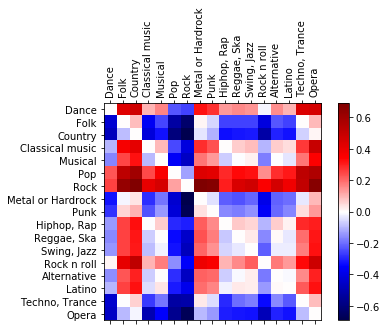

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def show_matrix(matrix):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.matshow(matrix, cmap='seismic')
    fig.colorbar(cax)
    # Axes
    ax.set_xticklabels([''] + matrix.columns.tolist(), rotation=90)
    ax.set_yticklabels([''] + matrix.columns.tolist())
    # Label pour chaque index
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
show_matrix(omega)

** Matrice de préférence sur l'ensemble du jeu de données **

### Interprétation sur l'ensemble des données :

On observe une diagonale blanche, puisqu'un style musical comparé à lui-même donne bien une préférence de zéro. Une case bleue signifie que le style en abscisse est moins apprécié que celui en ordonnée, et inversement pour une case rouge. 

On notera également qu'on obtient une matrice **antisymétrique**. Il suffit de prendre la matrice triangulaire inférieure ou supérieure à la diagonale blanche. En effet, soit m1 et m2 deux styles musicaux. On a dans la matrice omega deux cases comparant m1 et m2 : omega[m1][m2] et omega[m2][m1]. On a donc omega[m1][m2] = -omega[m2][m1], donc ces deux cases auront des couleurs opposées de même intensité. 

In [11]:
print(omega.columns[6], " compared to ", omega.columns[2], " is ", omega[omega.columns[2]][omega.columns[6]])

print(omega.columns[6], " compared to ", omega.columns[16], " is ", omega[omega.columns[16]][omega.columns[6]])

Rock  compared to  Country  is  0.6851485148514852
Rock  compared to  Opera  is  0.6702970297029703


La case omega[6][2] (resp. omega[2][6]) compare le Rock et la Country. On remarque que les individus préfèrent largement le Rock par exemple. Ils préfèrent aussi largement le Rock à l'Opéra. 

## Matrice de préférences sur différents groupes d'individus

On répète le même processus en ne prenant cette fois qu'une partie des individus du jeu de données. On pourra ensuite calculer la distance entre les matrices obtenues d'une part, la distance des matrices par rapport à celle de l'ensemble de la population. On pourra ainsi mettre en évidence des préférences exceptionnelles, c'est-à-dire en marge par rapport aux préférences majoritaires sur l'ensemble des individus de notre jeu de données. 

In [12]:
# on récupère seulement les données musicales des femmes 
# female -> 0
data_f = data.loc[data['Gender']== 0]
print("Données pour les femmes : ", data_f.shape)
data_f_music = data_f.iloc[:,2:19]
print("Données musicales des femmes : ", data_f_music.shape)
                     
# on récupère les données musicales des hommes
# male -> 1
data_m = data.loc[data['Gender']== 1]
print("Données pour les hommes : ", data_m.shape)
data_m_music = data_m.iloc[:,2:19]
print("Données musicales des hommes : ", data_m_music.shape)


Données pour les femmes :  (593, 150)
Données musicales des femmes :  (593, 17)
Données pour les hommes :  (411, 150)
Données musicales des hommes :  (411, 17)


On fait les deux matrices de préférences pour ces sous-groupes.

In [13]:
# on réindexe à partir de 0 pour pouvoir itérer sur les lignes
data_m_music = data_m_music.reset_index(drop=True)
omega_m = do_matrix_pref(data_m_music)

# on réindexe à partir de 0 pour pouvoir itérer sur les lignes
data_f_music = data_f_music.reset_index(drop=True)
omega_f = do_matrix_pref(data_f_music)

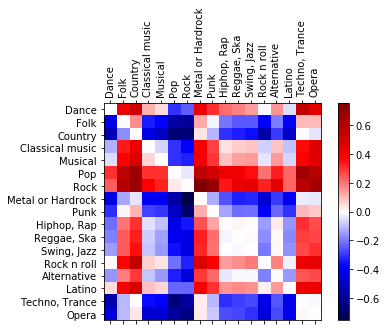

In [14]:
show_matrix(omega_f)

**Matrice de préférence pour les femmes **

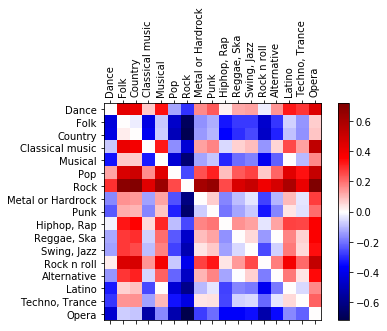

In [15]:
show_matrix(omega_m)

** Matrice de préférence pour les hommes **

On observe de grandes similarités entre les deux nouvelles matrices, et aussi par rapport à la matrice sur l'ensemble des individus. On remarque cependant certains éléments différents. Pour mettre en évidence les divergences entre ces matrices, on calcule la distance entre elles, c'est-à-dire pour chaque élément la variation entre la matrice générale et celle du sous-groupe. 
Un comportement exceptionnel pour un facteur devra donner une distance toujours différente de zéro. 

In [16]:
# matrix1 et matrix2 doivent avoir la même taille et même index de lignes et colonnes
def do_matrix_distance(matrix_dataset, matrix_subgroup):
    matrix_dist = pd.DataFrame(0.0,index=matrix_dataset.columns, columns=matrix_dataset.columns)
    for music1 in matrix_dataset.columns :
        for music2 in matrix_dataset.columns :
            matrix_dist[music1][music2] = (1/2)*(matrix_dataset[music1][music2]-matrix_subgroup[music1][music2])
    return matrix_dist

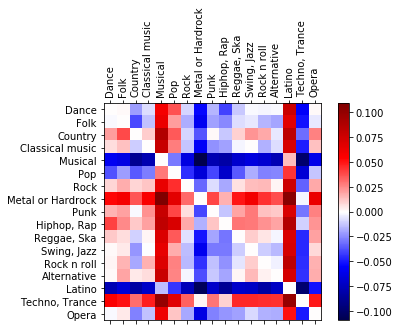

In [17]:
dist_f = do_matrix_distance(omega, omega_f)
show_matrix(dist_f)

** Evaluation des divergences des femmes par rapport à l'ensemble des données **

### Interprétation des matrices de distances pour les femmes : 

On observe une grande divergence quand au classement des musiques latines par rapport à l'ensemble de la population étudiée. Une importante différence négative (puisqu'en bleue) signifie que la musique Latine est plus souvent préférée aux autres dans le sous-groupe, comparé à l'ensemble des individus. A l'inverse, la musique Techno est moins bien classée que les autres styles musicaux pour les femmes. 

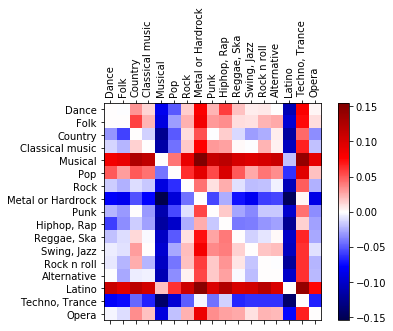

In [54]:
dist_m = do_matrix_distance(omega, omega_m)
show_matrix(dist_m)

** Evaluation des divergences des hommes par rapport à l'ensemble des données **

### Interprétation de la matrice de distance pour les hommes :

On observe la tendance inverse pour les hommes vis-à-vis des musiques latines et de la techno/trance. Cette observation a du sens, puisqu'en moyennant l'appréciation des femmes et des hommes, on retrouve l'appréciation de l'ensemble de la population, puisque la concaténation de ces deux groupes représente la quasi-totalité des données, moins les individus pour lesquelles la donnée 'Gender' n'est pas renseignée. 

A ce stade, l'intensité témoigne d'une valeur forte, donc d'une grande différence entre les matrices comparées. La couleur quant à elle, renseigne le sens de la divergence. Comme la distance est calculée commme la soustraction du sous-groupe au total, on distingue les cas suivants : 
- une valeur négative (en bleu) : le style musical est mieux noté dans le sous-groupe que dans l'ensemble de la population. 
- une valeur positive (en rouge) : le style musical est globalement plus apprécié par l'ensemble de la population. 
- une valeur proche de zéro (en blanc) : il n'y a pas de différence significative dans le classement relatif des styles de musiques.

In [20]:
# on récupère les données musicales des Romantiques :-)
data_r = data.loc[data['Romantic']>3]
data_r = data_r[data_r['Writing']>3]
print("Données pour les romantiques : ", data_r.shape)
data_r_music = data_r.iloc[:,2:19]
print("Données musicales des romantiques : ", data_r_music.shape)

Données pour les romantiques :  (25, 150)
Données musicales des romantiques :  (25, 17)


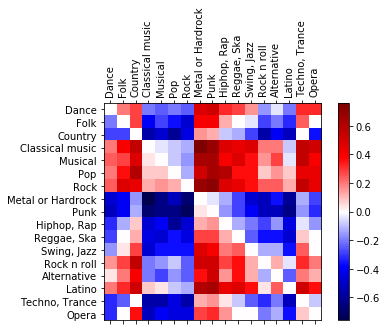

In [21]:
data_r_music = data_r_music.reset_index(drop=True)

omega_r = do_matrix_pref(data_r_music)
show_matrix(omega_r)

** Matrice de préférence des personnes romantiques, écrivant de la poésie **

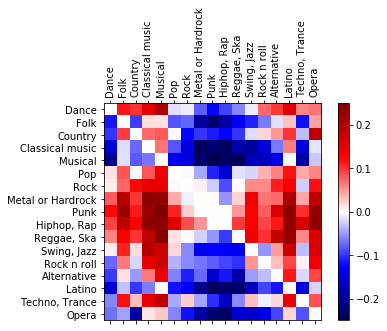

In [22]:
dist_r = do_matrix_distance(omega, omega_r)
show_matrix(dist_r)

** Matrice de distance des personnes romantiques écrivant de la poésie par rapport à l'ensemble des individus **

### Interprétation pour les personnes romantiques et poètes :

On observe ici qu'il y a quelques fortes déviations sur certains couples de styles musicaux. Cependant, pour beaucoup, on observe qu'il y a une distance faible entre les classements faits par le sous-groupe par rapport à l'ensemble de la population, ce qui est mis en évidence par le grand nombre de case blanche. En effet, les cases blanches ont une valeur proche de zéro, c'est à dire que le classement est à peu près équivalent pour les deux groupes d'individus considérés. 

In [53]:
# on récupère les données musicales des personnes qui peuvent changer de personnalité / lunatiques
data_fake = data.loc[data['Fake']>3]
print("Données pour les lunatiques : ", data_fake.shape)
data_fake_music = data_fake.iloc[:,2:19]
print("Données musicales des lunatiques : ", data_fake_music.shape)

Données pour les lunatiques :  (31, 150)
Données musicales des lunatiques :  (31, 17)


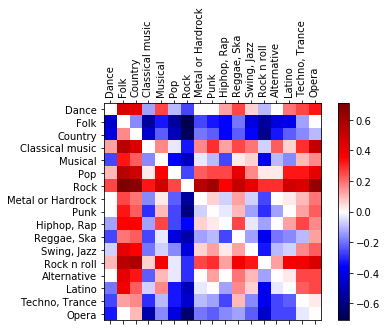

In [31]:
data_fake_music = data_fake_music.reset_index(drop=True)

omega_fake = do_matrix_pref(data_fake_music)
show_matrix(omega_fake)

** Matrice de préférence pour les personnes lunatiques **

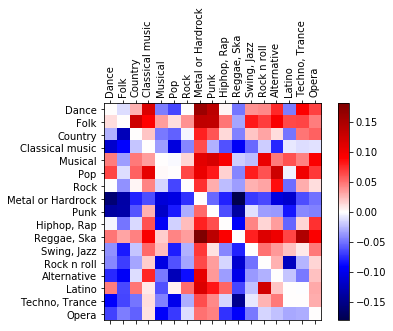

In [32]:
dist_fake = do_matrix_distance(omega, omega_fake)
show_matrix(dist_fake)

** Matrice de distance des personnes lunatiques par rapport à l'ensemble de la population **

### Interprétation :

On observe que l'intervalle de valeurs est restreint et que les couleurs sont peu intenses, témoignant de valeurs faibles. Il n'y a donc pas de fortes divergences. Ce sous-groupe est donc moins intéressant et moins significatif.

In [33]:
# on récupère les données musicales des solitaires
data_s = data.loc[data['Loneliness']>3]
data_s = data_s.loc[data_s['Gender']==0]
print("Données pour les solitaires : ", data_s.shape)
data_s_music = data_s.iloc[:,2:19]
print("Données musicales des romantiques : ", data_s_music.shape)

Données pour les solitaires :  (66, 150)
Données musicales des romantiques :  (66, 17)


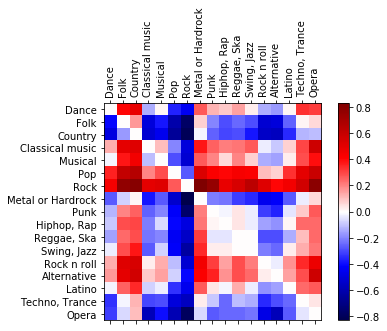

In [34]:
data_s_music = data_s_music.reset_index(drop=True)

omega_s = do_matrix_pref(data_s_music)
show_matrix(omega_s)

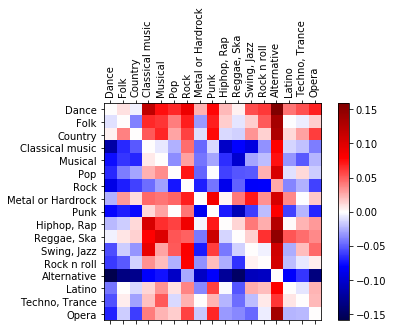

In [35]:
dist_s = do_matrix_distance(omega, omega_s)
show_matrix(dist_s)

** Matrice de distance pour les personnes solitaires **

### Interprétation :

On remarque ici également qu'il y a beaucoup de valeurs faibles, donc peu de distance, à l'exception du classement de la musique alternative. En effet, sur l'ensemble de la population, la musique alternative n'est pas systématiquement plus ou moins appréciée qu'un autre genre, le classement est relativement équilibré. En revanche, dans le sous-groupe des personnes solitaires, la musique alternative est majoritairement mieux noté que les autres genres musicaux.

## Labelwise : focus sur un seul élément

On peut également chercher si l'appréciation d'un style musical différe particulièrement dans un sous-groupe, indépendemment de sa comparaison avec les autres. On parcout donc les lignes de la matrice de distance pour trouver la valeur moyenne maximale, c'est-à-dire, on cherche l'élément qui a en moyenne la distance la plus élevée, donc une évaluation qui diffère grandement au sein du sous-groupe par rapport à l'ensemble des individus. 

In [52]:
# on affiche la moyenne de chaque ligne. 
print(dist_s.mean(axis = 1))

# on prend le maximum en valeur absolue.
print(dist_s.mean(axis=1).abs().max(axis=0))

Dance                0.054718
Folk                 0.026463
Country              0.033372
Classical music     -0.034183
Musical             -0.030889
Pop                 -0.005921
Rock                -0.051565
Metal or Hardrock    0.036474
Punk                -0.033020
Hiphop, Rap          0.036746
Reggae, Ska          0.042205
Swing, Jazz          0.013468
Rock n roll         -0.001856
Alternative         -0.098037
Latino               0.008831
Techno, Trance       0.002421
Opera                0.000775
dtype: float64
0.09803745080390393


On observe que la valeur maximale correspond à la musique alternative, ce qui correspond bien aux observations faites sur la matrice de distance. 

On peut répéter l'opération sur tous les sous-groupes, mais aussi tester de nombreux autres sous-groupes pour en trouver des plus significatifs. Cela permettra d'extraire à la fois les sous-groupes présentant des caractéristiques particulières, et les critères qui ont un comportement exceptionnel pour ces sous-groupes. 